End-to-end (current focus: Readmission with XGBoost + Optuna). Structure prepared for mortality & prolonged LOS later.

In [1]:
# Environment & core imports
import os, sys, json, random, platform, importlib, datetime, pathlib
from pathlib import Path
import numpy as np, pandas as pd

# Add project root to path if notebook is under notebooks/
ROOT = pathlib.Path(__file__).resolve().parents[1] if '__file__' in globals() else pathlib.Path.cwd().parents[0]
if str(ROOT) not in sys.path: sys.path.insert(0, str(ROOT))


SEED = 42
random.seed(SEED); np.random.seed(SEED)
PROJECT_ROOT = (Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd())
DATA_DIR = PROJECT_ROOT / 'data'
ARTIFACTS_DIR = PROJECT_ROOT / 'project/artifacts'
RUNS_ROOT = PROJECT_ROOT / 'runs'
print(f"Project root: {PROJECT_ROOT}")
print(f"Data dir exists: {(DATA_DIR).exists()}")
VERSIONS = {'python': sys.version.split()[0], 'platform': platform.platform()}
for pkg in ['xgboost','optuna','shap','sklearn','pandas','numpy']:
    try:
        m = importlib.import_module(pkg if pkg != 'sklearn' else 'sklearn')
        VERSIONS[pkg] = getattr(m,'__version__','?')
    except Exception as e:
        VERSIONS[pkg] = f'NA({e})'
print('Versions:', json.dumps(VERSIONS, indent=2))

Project root: c:\Users\Almog Luz\Documents\GitHub\mlhc-final-project
Data dir exists: True
Versions: {
  "python": "3.13.3",
  "platform": "Windows-10-10.0.19045-SP0",
  "xgboost": "2.1.1",
  "optuna": "4.5.0",
  "shap": "0.48.0",
  "sklearn": "1.7.1",
  "pandas": "2.3.1",
  "numpy": "2.2.6"
}
Versions: {
  "python": "3.13.3",
  "platform": "Windows-10-10.0.19045-SP0",
  "xgboost": "2.1.1",
  "optuna": "4.5.0",
  "shap": "0.48.0",
  "sklearn": "1.7.1",
  "pandas": "2.3.1",
  "numpy": "2.2.6"
}


### Labels
Load readmission labels (or synthesize) and report prevalence.

In [2]:
# Load canonical labels produced by duckdb_extraction notebook
import pandas as pd, random
from pathlib import Path

# Force single authoritative path (output of duckdb_extraction)
LABELS_PATH = (PROJECT_ROOT / 'project' / 'artifacts' / 'labels.csv')
if not LABELS_PATH.exists():
    raise FileNotFoundError(f'Expected labels at {LABELS_PATH}. Run duckdb_extraction notebook first to generate labels.csv there.')

labels_df = pd.read_csv(LABELS_PATH)
# Normalize required columns
required_cols = {'subject_id','hadm_id','readmission_label','mortality_label','prolonged_los_label'}
missing = required_cols - set(labels_df.columns)
if missing:
    raise ValueError(f'Missing expected label columns in {LABELS_PATH}: {missing}')

labels_df = labels_df.drop_duplicates('subject_id')
for col in ['readmission_label','mortality_label','prolonged_los_label']:
    labels_df[col] = labels_df[col].astype(int)
assert labels_df['subject_id'].isna().sum()==0
prev_readmit = labels_df['readmission_label'].mean()
print(f'Labels source: {LABELS_PATH} | shape={labels_df.shape} | readmission_prevalence={prev_readmit:.4f}')

Labels source: c:\Users\Almog Luz\Documents\GitHub\mlhc-final-project\project\artifacts\labels.csv | shape=(28340, 5) | readmission_prevalence=0.0435


### Features
Load (or regenerate) prepared feature matrix aligned to subjects.

In [3]:
# Load feature matrix (regenerate if tiny/corrupt) + strict safe alignment
import pandas as pd, numpy as np, json, os
from pathlib import Path

feature_path = ARTIFACTS_DIR / 'features_full.parquet'
if not feature_path.exists():
    raise FileNotFoundError(f'Missing feature parquet: {feature_path}')

feature_df = pd.read_parquet(feature_path)
regenerated = False  # placeholder if regeneration logic later added

# Ensure subject_id index
if 'subject_id' in feature_df.columns:
    if feature_df['subject_id'].duplicated().any():
        raise RuntimeError('Duplicate subject_id rows in feature parquet.')
    feature_df = feature_df.set_index('subject_id')

# Canonical integer index (fix KeyError mismatch from mixed string/int earlier)
try:
    feature_df.index = feature_df.index.astype(int)
except Exception as e:
    raise RuntimeError(f'Failed to coerce feature index to int: {e}')
if feature_df.index.has_duplicates:
    raise RuntimeError('Feature index has duplicates after int coercion.')

# Labels already loaded upstream into labels_df
label_subjects = labels_df['subject_id'].astype(int)

feat_ids = feature_df.index
missing_in_features = set(label_subjects) - set(feat_ids)
extra_in_features = set(feat_ids) - set(label_subjects)
overlap_frac = 1 - (len(missing_in_features)/len(label_subjects)) if len(label_subjects) else 0
print(f"[cohort-diff] label_subjects={len(label_subjects)} feature_subjects={len(feat_ids)}")
print(f"[cohort-diff] missing_in_features={len(missing_in_features)} extra_in_features={len(extra_in_features)}")
print(f"[align] overlap_frac={overlap_frac:.4f}")

if missing_in_features:
    raise RuntimeError(f'Missing {len(missing_in_features)} subjects (sample: {list(missing_in_features)[:10]})')

# Pre-alignment variance snapshot (for collapse detection)
pre_var = feature_df.var(numeric_only=True, ddof=0)

# Strict ordering alignment
feature_df_aligned = feature_df.loc[label_subjects.values]

post_var = feature_df_aligned.var(numeric_only=True, ddof=0)
collapsed = [c for c in pre_var.index if pre_var[c] > 0 and post_var[c] == 0]
if collapsed:
    print(f'WARNING: {len(collapsed)} columns lost variance post-alignment (e.g. {collapsed[:5]}).')
else:
    print('[align] Variance preserved.')

print('Features aligned shape:', feature_df_aligned.shape, '| regenerated' if regenerated else '')

# Expose for downstream cells
features_loaded = feature_df_aligned

[cohort-diff] label_subjects=28340 feature_subjects=28340
[cohort-diff] missing_in_features=0 extra_in_features=0
[align] overlap_frac=1.0000
[align] Variance preserved.
Features aligned shape: (28340, 1500) 
[align] Variance preserved.
Features aligned shape: (28340, 1500) 


In [4]:
# Diagnostic: Flat / Near-Flat Feature Scan (post-load)
import pandas as pd, numpy as np, math, json, os, time
from pathlib import Path

# Expect a DataFrame named `features_loaded` or `features` from previous cell.
# Try common variable names.
_df = None
for name in ['features_loaded','features','X','features_full', "feature_df"]:
    if name in globals():
        obj = globals()[name]
        if isinstance(obj, pd.DataFrame):
            _df = obj
            break
if _df is None:
    raise RuntimeError('No feature DataFrame (features_loaded/features/X) found for flatness scan.')

print(f'[flatness-scan] Feature matrix shape: {_df.shape}')

# Numeric subset only
num_df = _df.select_dtypes(include=[np.number])
if num_df.empty:
    raise RuntimeError('No numeric columns to scan.')

std_series = num_df.std(ddof=0)
var_series = num_df.var(ddof=0)
missing_frac = num_df.isna().mean()
unique_counts = num_df.nunique(dropna=True)

# Dominant value fraction (highest frequency / count)
dom_frac = {}
for c in num_df.columns:
    vc = num_df[c].value_counts(dropna=True)
    if vc.empty:
        dom_frac[c] = math.nan
    else:
        dom_frac[c] = float(vc.iloc[0] / vc.sum())

dom_frac = pd.Series(dom_frac)

flat = var_series[var_series == 0.0].index.tolist()
near_flat = var_series[(var_series > 0.0) & (var_series < 1e-10)].index.tolist()
very_low_var = var_series[(var_series >= 1e-10) & (var_series < 1e-6)].index.tolist()

dominant_high = dom_frac[dom_frac >= 0.995].index.tolist()

print(f'[flatness-scan] zero-variance: {len(flat)}  near-zero(<1e-10): {len(near_flat)}  very-low(<1e-6): {len(very_low_var)}  dominant(top>=99.5%): {len(dominant_high)}')

# Summaries
def summary_list(cols, label, limit=15):
    if not cols:
        print(f'  {label}: none')
        return
    print(f'  {label} (showing up to {limit}):')
    for c in cols[:limit]:
        print(f'    - {c} | var={var_series[c]:.3e} std={std_series[c]:.3e} miss={missing_frac[c]:.3f} uniq={unique_counts[c]} dom={dom_frac[c]:.3f}')

summary_list(flat, 'Zero variance')
summary_list(near_flat, 'Near-zero variance (<1e-10)')
summary_list(very_low_var, 'Very-low variance (<1e-6)')
summary_list(dominant_high, 'Dominant single value (>=99.5%)')

# Aggregate distribution of std for a quick health view
bins = [-1,0,1e-10,1e-6,1e-3,1e-1,1,10,100,1e6]
std_hist = std_series.groupby(pd.cut(std_series, bins=bins)).size()
print('\n[flatness-scan] Std distribution buckets:')
print(std_hist)

# Optional: produce a DataFrame for downstream interactive analysis
flatness_report = pd.DataFrame({
    'var': var_series,
    'std': std_series,
    'missing_frac': missing_frac,
    'n_unique': unique_counts,
    'dominant_frac': dom_frac,
})
flatness_report['is_zero_var'] = flatness_report['var'] == 0.0
flatness_report['is_near_zero_var'] = (flatness_report['var'] > 0) & (flatness_report['var'] < 1e-10)
flatness_report['is_dominant'] = flatness_report['dominant_frac'] >= 0.995

print('\n[flatness-scan] flatness_report head:')
display(flatness_report.head())

# Flag if excessive collapse
zero_ratio = len(flat) / len(num_df.columns)
if zero_ratio > 0.2:
    print(f'WARNING: High fraction of zero-variance columns ({zero_ratio:.1%})')

print('[flatness-scan] Complete.')

[flatness-scan] Feature matrix shape: (28340, 1500)
[flatness-scan] zero-variance: 0  near-zero(<1e-10): 0  very-low(<1e-6): 0  dominant(top>=99.5%): 536
  Zero variance: none
  Near-zero variance (<1e-10): none
  Very-low variance (<1e-6): none
  Dominant single value (>=99.5%) (showing up to 15):
    - lactate dehydrogenase, ascites__measured | var=4.803e-03 std=6.930e-02 miss=0.028 uniq=2 dom=0.995
    - acetaminophen__measured | var=4.551e-03 std=6.746e-02 miss=0.028 uniq=2 dom=0.995
    - glucose, ascites__measured | var=4.443e-03 std=6.666e-02 miss=0.028 uniq=2 dom=0.996
    - phosphate, urine__measured | var=4.335e-03 std=6.584e-02 miss=0.028 uniq=2 dom=0.996
    - total protein, body fluid__measured | var=4.263e-03 std=6.529e-02 miss=0.028 uniq=2 dom=0.996
    - other cells__measured | var=4.191e-03 std=6.474e-02 miss=0.028 uniq=2 dom=0.996
    - valproic acid__measured_y | var=4.191e-03 std=6.474e-02 miss=0.028 uniq=2 dom=0.996
    - other__measured | var=4.155e-03 std=6.446e-

C:\Users\Almog Luz\AppData\Local\Temp\ipykernel_3348\2020364631.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  std_hist = std_series.groupby(pd.cut(std_series, bins=bins)).size()


,var,std,missing_frac,n_unique,dominant_frac,is_zero_var,is_near_zero_var,is_dominant
hematocrit (serum)__range,1.085063e+10,104166.378114,0.674841,521,0.149322,False,False,False
hematocrit (serum)__max,1.085062e+10,104166.299766,0.674841,328,0.009441,False,False,False
"rbc, other fluid__min",2.151631e+11,463856.799948,0.993402,92,0.486631,False,False,False
"rbc, other fluid__last",2.151631e+11,463856.799948,0.993402,92,0.486631,False,False,False
"rbc, other fluid__mean",2.151555e+11,463848.592708,0.993402,92,0.481283,False,False,False


[flatness-scan] Complete.


In [5]:
# Deep variance trace: rebuild features fresh and compare to loaded parquet
import pandas as pd, numpy as np
from pathlib import Path
import importlib

ART_DIR = ARTIFACTS_DIR if 'ARTIFACTS_DIR' in globals() else Path.cwd()/ 'project' / 'artifacts'
parquet_path = ART_DIR / 'features_full.parquet'
if not parquet_path.exists():
    raise FileNotFoundError(f'Missing parquet at {parquet_path}')

loaded_df = None
for name in ['features_loaded','features','X','features_full']:
    if name in globals() and isinstance(globals()[name], pd.DataFrame):
        loaded_df = globals()[name]
        break
if loaded_df is None:
    loaded_df = pd.read_parquet(parquet_path)

print('[variance-trace] Loaded (disk) shape:', loaded_df.shape)
print('[variance-trace] Loaded nunique>1 count:', (loaded_df.nunique(dropna=True)>1).sum())

# Attempt rebuild using pipeline (training-side) WITHOUT persistence.
try:
    import duckdb

    PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
    DATA_DIR = PROJECT_ROOT / 'data'
    ARTIFACTS_DIR = PROJECT_ROOT / 'project' / 'artifacts'
    DB_PATH = DATA_DIR / 'mimiciii.duckdb'  # Adjust if your filename differs
    SUBJECT_SAMPLE_LIMIT = None  # e.g., 500 for a quick run; set None for full
    RANDOM_SEED = 42

    con = duckdb.connect(str(DB_PATH))
    print('Connected to DuckDB.')
    # (Optional) list tables to verify schema
    try:
        tbls = con.execute("SHOW TABLES").fetchdf()
        print('Available tables:', tbls['name'].tolist())
    except Exception as e:
        print('Could not list tables:', e)

    import project.pipeline_core as pc
    importlib.reload(pc)
    # Need a cohort subject list: derive from labels or index if present
    subj_source = None
    if 'labels_df' in globals() and isinstance(labels_df, pd.DataFrame) and not labels_df.empty:
        subj_source = labels_df['subject_id'].astype(int).tolist()
    elif 'labels' in globals() and isinstance(labels, pd.DataFrame) and not labels.empty:
        subj_source = labels['subject_id'].astype(int).tolist()
    else:
        # fallback from loaded features index or column
        if loaded_df.index.name == 'subject_id' or 'subject_id' in loaded_df.columns:
            subj_source = (loaded_df.index if loaded_df.index.name=='subject_id' else loaded_df['subject_id']).astype(int).tolist()
    if subj_source is None:
        raise RuntimeError('Could not determine subject list for rebuild.')
    # Connect (assumes `con` live from earlier cell)
    rebuilt_feats, rebuilt_labels, dbg2 = pc.run_training_side_pipeline(
        con,
        cohort_subject_ids=subj_source,
        debug=True
    )
    print('[variance-trace] Rebuilt shape:', rebuilt_feats.shape)
    print('[variance-trace] Rebuilt nunique>1 count:', (rebuilt_feats.nunique(dropna=True)>1).sum())
    # Align to same columns (union) and compare variance patterns
    common = [c for c in loaded_df.columns if c in rebuilt_feats.columns]
    print('[variance-trace] Common column count:', len(common))
    if len(common)==0:
        print('No overlapping columns to compare.')
    else:
        loaded_var = loaded_df[common].nunique(dropna=True)
        rebuilt_var = rebuilt_feats[common].nunique(dropna=True)
        both_constant = ((loaded_var<=1) & (rebuilt_var<=1)).sum()
        loaded_only_constant = ((loaded_var<=1) & (rebuilt_var>1)).sum()
        rebuilt_only_constant = ((rebuilt_var<=1) & (loaded_var>1)).sum()
        print(f'[variance-trace] both_constant={both_constant} loaded_only_constant={loaded_only_constant} rebuilt_only_constant={rebuilt_only_constant}')
        if loaded_only_constant>0:
            offenders = [c for c in common if (loaded_var[c]<=1 and rebuilt_var[c]>1)][:15]
            print('[variance-trace] Example columns constant on disk but variable when rebuilt:', offenders)
        if rebuilt_only_constant>0:
            offenders2 = [c for c in common if (rebuilt_var[c]<=1 and loaded_var[c]>1)][:15]
            print('[variance-trace] Example columns constant when rebuilt but variable on disk:', offenders2)
except Exception as e:
    print('Variance trace rebuild failed ->', e)

print('[variance-trace] Complete.')

[variance-trace] Loaded (disk) shape: (28340, 1500)
[variance-trace] Loaded nunique>1 count: 1500
Variance trace rebuild failed -> IO Error: Cannot open file "c:\users\almog luz\documents\github\mlhc-final-project\data\mimiciii.duckdb": The process cannot access the file because it is being used by another process.

File is already open in 
C:\Users\Almog Luz\Documents\GitHub\mlhc-final-project\.venv\Scripts\python.exe (PID 22028)
[variance-trace] Complete.
[variance-trace] Loaded nunique>1 count: 1500
Variance trace rebuild failed -> IO Error: Cannot open file "c:\users\almog luz\documents\github\mlhc-final-project\data\mimiciii.duckdb": The process cannot access the file because it is being used by another process.

File is already open in 
C:\Users\Almog Luz\Documents\GitHub\mlhc-final-project\.venv\Scripts\python.exe (PID 22028)
[variance-trace] Complete.


### Train/Validation/Test Split
Create 60/20/20 stratified split and compute imbalance weight.

In [6]:
# Train/valid/test split (60/20/20) + class weight factor
from sklearn.model_selection import train_test_split
readmit_y = labels_df['readmission_label'].astype(int).to_numpy()
subject_index = feature_df.index.to_numpy()
X = feature_df.values
X_tr, X_temp, y_tr, y_temp, sid_tr, sid_temp = train_test_split(
    X, readmit_y, subject_index, test_size=0.4, stratify=readmit_y, random_state=SEED)
X_val, X_te, y_val, y_te, sid_val, sid_te = train_test_split(
    X_temp, y_temp, sid_temp, test_size=0.5, stratify=y_temp, random_state=SEED)
pos_rate = y_tr.mean(); scale_pos_weight = (1-pos_rate)/max(pos_rate,1e-6)
print(f'Split -> train {X_tr.shape} valid {X_val.shape} test {X_te.shape} | pos_rate_train={pos_rate:.4f} | spw≈{scale_pos_weight:.2f}')

Split -> train (17004, 1500) valid (5668, 1500) test (5668, 1500) | pos_rate_train=0.0435 | spw≈22.01


### Metrics Helpers
Utility functions to compute threshold-dependent metrics and cost.

In [7]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, confusion_matrix
import numpy as np
C_FP = 1.0; C_FN = 5.0
beta = 2.0

def metrics_at(proba, y, thr):
    pred = (proba >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, pred).ravel()
    cost = C_FP*fp + C_FN*fn
    f1 = f1_score(y, pred)
    prec = tp/(tp+fp+1e-9); rec = tp/(tp+fn+1e-9)
    fbeta = (1+beta**2)*prec*rec/(beta**2*prec+rec+1e-9)
    return dict(f1=f1, precision=prec, recall=rec, cost=cost, fbeta=fbeta)

### Split data to train/validation/test with targets
Stratified 60/20/20 split (shared across targets for matched cohorts)


In [8]:

SEED = 42
rng_global = np.random.default_rng(SEED)

TARGET_SPECS = [
    ('readmission','readmission_label'),
    ('mortality','mortality_label'),
    ('prolonged_los','prolonged_los_label'),
]


# Verify presence of target columns
missing_targets = [lbl for _,lbl in TARGET_SPECS if lbl not in labels_df.columns]
if missing_targets:
    raise ValueError(f"Missing target label columns: {missing_targets}")

# Shared subject index + base split for comparability
subject_index = feature_df.index.to_numpy()
X = feature_df.values
primary_y = labels_df[TARGET_SPECS[0][1]].astype(int).to_numpy()  # stratify on first target
X_tr, X_temp, y_tr_primary, y_temp_primary, sid_tr, sid_temp = train_test_split(X, primary_y, subject_index, test_size=0.4, stratify=primary_y, random_state=SEED)
X_val, X_te, y_val_primary, y_te_primary, sid_val, sid_te = train_test_split(X_temp, y_temp_primary, sid_temp, test_size=0.5, stratify=y_temp_primary, random_state=SEED)
print(f'Shared split shapes -> train {X_tr.shape} val {X_val.shape} test {X_te.shape}')

subj_to_pos = {sid:i for i,sid in enumerate(subject_index)}
idx_tr = np.array([subj_to_pos[s] for s in sid_tr])
idx_val = np.array([subj_to_pos[s] for s in sid_val])
idx_te = np.array([subj_to_pos[s] for s in sid_te])
metrics_all = {}


Shared split shapes -> train (17004, 1500) val (5668, 1500) test (5668, 1500)


## Baseline Models

In [9]:
# Multi-target baseline (logistic) for reference per target
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

baseline_results = {}
X_base = X_tr  # using training split from shared split
X_val_base = X_val

for tgt_name, label_col in TARGET_SPECS:
    y_tr_t = labels_df[label_col].astype(int).to_numpy()[idx_tr]
    y_val_t = labels_df[label_col].astype(int).to_numpy()[idx_val]
    pipe = Pipeline([
        ("imp", SimpleImputer(strategy='median')),
        ("sc", StandardScaler(with_mean=False)),
        ("lr", LogisticRegression(max_iter=500, class_weight='balanced', solver='liblinear'))
    ])
    pipe.fit(X_base, y_tr_t)
    val_proba = pipe.predict_proba(X_val_base)[:,1]
    auc_val = roc_auc_score(y_val_t, val_proba)
    baseline_results[tgt_name] = float(auc_val)
print('Baseline logistic validation AUCs per target:', baseline_results)

Baseline logistic validation AUCs per target: {'readmission': 0.5874545458619089, 'mortality': 0.7923179508441571, 'prolonged_los': 0.8021399656370639}


### Multi-Target Hyperparameter Tuning
We run an Optuna study separately for each target (readmission, mortality, prolonged LOS) using the same feature matrix & subject-aligned train/val/test split for comparability. Each target gets:
1. Optuna CV objective (5-fold on training portion only)
2. Final model retrained on train+validation
3. Isotonic calibration on validation
4. Threshold selection (max F1 on calibrated validation)
5. Test evaluation & artifact persistence
All artifacts written to `artifacts/` with target-specific prefixes.

In [ ]:
# Multi-target tuning & training pipeline (updated to persist final_model + artifact paths)
import optuna, numpy as np, json, joblib
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
from xgboost import XGBClassifier


# Hyperparameter search configuration
N_TRIALS_PER_TARGET = 15  # increase for better tuning
N_FOLDS = 5
MAX_ROUNDS = 400
SPEED_SAMPLE_MAX = 12000

def make_objective(X_train_full, y_train_full):
    def objective(trial: optuna.Trial):
        params = {
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 7),
            'min_child_weight': trial.suggest_float('min_child_weight', 1.0, 8.0),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_lambda': trial.suggest_float('lambda', 1e-3, 5.0, log=True),
            'reg_alpha': trial.suggest_float('alpha', 1e-3, 2.0, log=True),
            'gamma': trial.suggest_float('gamma', 0.0, 4.0),
            'n_estimators': trial.suggest_int('n_estimators', 120, MAX_ROUNDS),
        }
        fold_aucs = []
        skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
        for fold,(tr_idx_local, va_idx_local) in enumerate(skf.split(X_train_full, y_train_full), 1):
            Xtr_f, Xva_f = X_train_full[tr_idx_local], X_train_full[va_idx_local]
            ytr_f, yva_f = y_train_full[tr_idx_local], y_train_full[va_idx_local]
            if Xtr_f.shape[0] > SPEED_SAMPLE_MAX:
                pos_idx = np.where(ytr_f==1)[0]
                neg_idx = np.where(ytr_f==0)[0]
                keep_pos = pos_idx
                remaining = SPEED_SAMPLE_MAX - len(keep_pos)
                if remaining < len(neg_idx):
                    keep_neg = np.random.default_rng(SEED+fold).choice(neg_idx, size=remaining, replace=False)
                else:
                    keep_neg = neg_idx
                keep = np.concatenate([keep_pos, keep_neg])
                np.random.default_rng(SEED+fold).shuffle(keep)
                Xtr_f = Xtr_f[keep]; ytr_f = ytr_f[keep]
            pos_rate_fold = ytr_f.mean(); spw = (1-pos_rate_fold)/max(pos_rate_fold,1e-6)
            model = XGBClassifier(objective='binary:logistic', tree_method='hist', scale_pos_weight=spw, eval_metric='auc', verbosity=0, **params)
            model.fit(Xtr_f, ytr_f, verbose=False)
            proba = model.predict_proba(Xva_f)[:,1]
            fold_auc = roc_auc_score(yva_f, proba)
            fold_aucs.append(fold_auc)
        mean_auc = float(np.mean(fold_aucs))
        trial.set_user_attr('fold_aucs', fold_aucs)
        trial.set_user_attr('cv_mean_auc', mean_auc)
        return mean_auc
    return objective

for tgt_name, label_col in TARGET_SPECS:
    print('\n==== Target:', tgt_name, '('+label_col+') ====')
    y_all = labels_df[label_col].astype(int).to_numpy()
    y_tr_t = y_all[idx_tr]; y_val_t = y_all[idx_val]; y_te_t = y_all[idx_te]
    pos_rate = y_tr_t.mean(); scale_pos_weight = (1-pos_rate)/max(pos_rate,1e-6)
    print(f'Pos rate train: {pos_rate:.4f} -> spw {scale_pos_weight:.2f}')
    sampler = optuna.samplers.TPESampler(seed=SEED)
    study = optuna.create_study(direction='maximize', sampler=sampler)
    objective = make_objective(X_tr, y_tr_t)
    study.optimize(objective, n_trials=N_TRIALS_PER_TARGET, show_progress_bar=False)
    best_params = study.best_params.copy()
    print('Best CV mean AUC:', round(study.best_value,4))
    print('Best Params:', best_params)
    # Final model retrained on train + validation (for potential deployment / ensembling)
    X_tr_full_t = np.vstack([X_tr, X_val])
    y_tr_full_t = np.concatenate([y_tr_t, y_val_t])
    final_model = XGBClassifier(objective='binary:logistic', tree_method='hist', learning_rate=best_params['learning_rate'], n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], min_child_weight=best_params['min_child_weight'], subsample=best_params['subsample'], colsample_bytree=best_params['colsample_bytree'], reg_lambda=best_params['lambda'], reg_alpha=best_params['alpha'], gamma=best_params['gamma'], scale_pos_weight=scale_pos_weight, eval_metric='auc', verbosity=0)
    final_model.fit(X_tr_full_t, y_tr_full_t)
    # Calibration base model (train-only) to avoid leaking validation into both model weights and calibrator
    base_model = XGBClassifier(objective='binary:logistic', tree_method='hist', learning_rate=best_params['learning_rate'], n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], min_child_weight=best_params['min_child_weight'], subsample=best_params['subsample'], colsample_bytree=best_params['colsample_bytree'], reg_lambda=best_params['lambda'], reg_alpha=best_params['alpha'], gamma=best_params['gamma'], scale_pos_weight=scale_pos_weight, eval_metric='logloss', verbosity=0)
    base_model.fit(X_tr, y_tr_t)
    val_raw = base_model.predict_proba(X_val)[:,1]
    iso = IsotonicRegression(out_of_bounds='clip'); iso.fit(val_raw, y_val_t)
    val_cal = iso.transform(val_raw)
    # Threshold selection on calibrated validation probabilities (maximize F1)
    ths = np.linspace(0.01,0.9,300)
    best_thr = None; best_f1 = -1; best_val_metrics = None
    def _metrics_at(proba, y, thr):
        pred = (proba >= thr).astype(int)
        tp = ((pred==1)&(y==1)).sum(); fp = ((pred==1)&(y==0)).sum(); fn = ((pred==0)&(y==1)).sum()
        prec = tp/(tp+fp+1e-9); rec = tp/(tp+fn+1e-9)
        f1 = 2*prec*rec/(prec+rec+1e-9)
        return dict(precision=float(prec), recall=float(rec), f1=float(f1))
    for t in ths:
        m = _metrics_at(val_cal, y_val_t, t)
        if m['f1'] > best_f1:
            best_f1 = m['f1']; best_thr = float(t); best_val_metrics = m
    print('Selected threshold (validation calibrated):', best_thr, best_val_metrics)
    # Test evaluation using calibrated base model
    test_cal = iso.transform(base_model.predict_proba(X_te)[:,1])
    auc = roc_auc_score(y_te_t, test_cal)
    pr_auc = average_precision_score(y_te_t, test_cal)
    brier = brier_score_loss(y_te_t, test_cal)
    test_pred = (test_cal >= best_thr).astype(int)
    tp = ((test_pred==1)&(y_te_t==1)).sum(); fp = ((test_pred==1)&(y_te_t==0)).sum(); fn = ((test_pred==0)&(y_te_t==1)).sum()
    prec_test = tp/(tp+fp+1e-9); rec_test = tp/(tp+fn+1e-9)
    f1_test = 2*prec_test*rec_test/(prec_test+rec_test+1e-9)
    metrics = {'auc': float(auc), 'pr_auc': float(pr_auc), 'brier': float(brier), 'threshold': best_thr, 'f1_at_threshold': float(f1_test), 'precision_at_threshold': float(prec_test), 'recall_at_threshold': float(rec_test), 'validation_threshold_info': {**best_val_metrics, 'threshold': best_thr}, 'optuna_best_value_cv_mean_auc': float(study.best_value), 'optuna_best_params': best_params, 'train_rows': int(X_tr.shape[0]), 'val_rows': int(X_val.shape[0]), 'test_rows': int(X_te.shape[0])}
    metrics_all[tgt_name] = metrics
    print('Test metrics:', json.dumps(metrics, indent=2))
    # Persist artifacts (both final_model and calibration pipeline components)
    ARTIFACTS_DIR.mkdir(exist_ok=True)
    final_path = ARTIFACTS_DIR / f'model_full_{tgt_name}.joblib'  # trained on train+val
    base_path = ARTIFACTS_DIR / f'model_{tgt_name}.joblib'        # train-only (paired with isotonic)
    iso_path = ARTIFACTS_DIR / f'isotonic_{tgt_name}.joblib'
    joblib.dump(final_model, final_path)
    joblib.dump(base_model, base_path)
    joblib.dump(iso, iso_path)
    with open(ARTIFACTS_DIR / f'metrics_{tgt_name}.json','w') as f: json.dump(metrics, f, indent=2)
    with open(ARTIFACTS_DIR / f'threshold_{tgt_name}.txt','w') as f: f.write(str(best_thr))
    with open(ARTIFACTS_DIR / f'best_params_{tgt_name}.json','w') as f: json.dump(best_params, f, indent=2)
    print(f'Artifact paths ({tgt_name}):')
    for p in [final_path, base_path, iso_path, ARTIFACTS_DIR / f'metrics_{tgt_name}.json', ARTIFACTS_DIR / f'threshold_{tgt_name}.txt', ARTIFACTS_DIR / f'best_params_{tgt_name}.json']:
        print('  -', p.resolve())


[I 2025-09-19 11:31:11,465] A new study created in memory with name: no-name-4a7032d7-471a-460d-a6c1-b8864dc43afc



==== Target: readmission (readmission_label) ====
Pos rate train: 0.0435 -> spw 22.01


[I 2025-09-19 11:31:38,135] Trial 0 finished with value: 0.6255218696679327 and parameters: {'learning_rate': 0.030710573677773714, 'max_depth': 7, 'min_child_weight': 6.123957592679836, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'lambda': 0.003775887545682684, 'alpha': 0.0015550191654264875, 'gamma': 3.4647045830997407, 'n_estimators': 288}. Best is trial 0 with value: 0.6255218696679327.
[I 2025-09-19 11:31:56,354] Trial 1 finished with value: 0.6223374599214484 and parameters: {'learning_rate': 0.08341106432362087, 'max_depth': 3, 'min_child_weight': 7.78936896513396, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'lambda': 0.004705059281907645, 'alpha': 0.004031102009377833, 'gamma': 1.216968971838151, 'n_estimators': 267}. Best is trial 0 with value: 0.6255218696679327.
[I 2025-09-19 11:31:56,354] Trial 1 finished with value: 0.6223374599214484 and parameters: {'learning_rate': 0.08341106432362087, 'max_depth': 3, 'min_child_

Best CV mean AUC: 0.6395
Best Params: {'learning_rate': 0.0249064396938244, 'max_depth': 3, 'min_child_weight': 5.789631185585098, 'subsample': 0.7760609974958406, 'colsample_bytree': 0.6488152939379115, 'lambda': 0.06786479434196534, 'alpha': 0.0012987260139887713, 'gamma': 3.6372816083151283, 'n_estimators': 192}


[I 2025-09-19 11:33:04,052] A new study created in memory with name: no-name-486debd8-d794-41e6-8748-e66d7e4bbce4


Selected threshold (validation calibrated): 0.054648829431438124 {'precision': 0.0708908406524022, 'recall': 0.457489878540658, 'f1': 0.12275936967519424}
Test metrics: {
  "auc": 0.6492485447724268,
  "pr_auc": 0.06760081502990012,
  "brier": 0.041148070462847075,
  "threshold": 0.054648829431438124,
  "f1_at_threshold": 0.12878787855694585,
  "precision_at_threshold": 0.07428214731580882,
  "recall_at_threshold": 0.4837398373964076,
  "validation_threshold_info": {
    "precision": 0.0708908406524022,
    "recall": 0.457489878540658,
    "f1": 0.12275936967519424,
    "threshold": 0.054648829431438124
  },
  "optuna_best_value_cv_mean_auc": 0.6395249280410231,
  "optuna_best_params": {
    "learning_rate": 0.0249064396938244,
    "max_depth": 3,
    "min_child_weight": 5.789631185585098,
    "subsample": 0.7760609974958406,
    "colsample_bytree": 0.6488152939379115,
    "lambda": 0.06786479434196534,
    "alpha": 0.0012987260139887713,
    "gamma": 3.6372816083151283,
    "n_estimat

[I 2025-09-19 11:33:37,696] Trial 0 finished with value: 0.8568201612196493 and parameters: {'learning_rate': 0.030710573677773714, 'max_depth': 7, 'min_child_weight': 6.123957592679836, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'lambda': 0.003775887545682684, 'alpha': 0.0015550191654264875, 'gamma': 3.4647045830997407, 'n_estimators': 288}. Best is trial 0 with value: 0.8568201612196493.
[I 2025-09-19 11:33:57,683] Trial 1 finished with value: 0.8545400944180246 and parameters: {'learning_rate': 0.08341106432362087, 'max_depth': 3, 'min_child_weight': 7.78936896513396, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'lambda': 0.004705059281907645, 'alpha': 0.004031102009377833, 'gamma': 1.216968971838151, 'n_estimators': 267}. Best is trial 0 with value: 0.8568201612196493.
[I 2025-09-19 11:33:57,683] Trial 1 finished with value: 0.8545400944180246 and parameters: {'learning_rate': 0.08341106432362087, 'max_depth': 3, 'min_child_

Best CV mean AUC: 0.8568
Best Params: {'learning_rate': 0.030710573677773714, 'max_depth': 7, 'min_child_weight': 6.123957592679836, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'lambda': 0.003775887545682684, 'alpha': 0.0015550191654264875, 'gamma': 3.4647045830997407, 'n_estimators': 288}


[I 2025-09-19 11:35:37,018] A new study created in memory with name: no-name-b88dafd9-be16-45e2-a849-d54a71c274e4


Selected threshold (validation calibrated): 0.20645484949832776 {'precision': 0.40312876052899743, 'recall': 0.5537190082635476, 'f1': 0.46657381566772355}
Test metrics: {
  "auc": 0.861057802986565,
  "pr_auc": 0.40082378929727874,
  "brier": 0.07499164910501352,
  "threshold": 0.20645484949832776,
  "f1_at_threshold": 0.44975404027082827,
  "precision_at_threshold": 0.3883495145626355,
  "recall_at_threshold": 0.5342237061760697,
  "validation_threshold_info": {
    "precision": 0.40312876052899743,
    "recall": 0.5537190082635476,
    "f1": 0.46657381566772355,
    "threshold": 0.20645484949832776
  },
  "optuna_best_value_cv_mean_auc": 0.8568201612196493,
  "optuna_best_params": {
    "learning_rate": 0.030710573677773714,
    "max_depth": 7,
    "min_child_weight": 6.123957592679836,
    "subsample": 0.8394633936788146,
    "colsample_bytree": 0.6624074561769746,
    "lambda": 0.003775887545682684,
    "alpha": 0.0015550191654264875,
    "gamma": 3.4647045830997407,
    "n_estima

[I 2025-09-19 11:36:16,843] Trial 0 finished with value: 0.8263831469691659 and parameters: {'learning_rate': 0.030710573677773714, 'max_depth': 7, 'min_child_weight': 6.123957592679836, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'lambda': 0.003775887545682684, 'alpha': 0.0015550191654264875, 'gamma': 3.4647045830997407, 'n_estimators': 288}. Best is trial 0 with value: 0.8263831469691659.
[I 2025-09-19 11:36:44,179] Trial 1 finished with value: 0.8227334915130197 and parameters: {'learning_rate': 0.08341106432362087, 'max_depth': 3, 'min_child_weight': 7.78936896513396, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'lambda': 0.004705059281907645, 'alpha': 0.004031102009377833, 'gamma': 1.216968971838151, 'n_estimators': 267}. Best is trial 0 with value: 0.8263831469691659.
[I 2025-09-19 11:36:44,179] Trial 1 finished with value: 0.8227334915130197 and parameters: {'learning_rate': 0.08341106432362087, 'max_depth': 3, 'min_child_

Best CV mean AUC: 0.8264
Best Params: {'learning_rate': 0.030710573677773714, 'max_depth': 7, 'min_child_weight': 6.123957592679836, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'lambda': 0.003775887545682684, 'alpha': 0.0015550191654264875, 'gamma': 3.4647045830997407, 'n_estimators': 288}
Selected threshold (validation calibrated): 0.3612374581939799 {'precision': 0.7085427135676414, 'recall': 0.8554095045497623, 'f1': 0.775080164414846}
Test metrics: {
  "auc": 0.8217653359985376,
  "pr_auc": 0.8069281973973844,
  "brier": 0.17139159587864938,
  "threshold": 0.3612374581939799,
  "f1_at_threshold": 0.7697918244552743,
  "precision_at_threshold": 0.7004977876104258,
  "recall_at_threshold": 0.854300168633776,
  "validation_threshold_info": {
    "precision": 0.7085427135676414,
    "recall": 0.8554095045497623,
    "f1": 0.775080164414846,
    "threshold": 0.3612374581939799
  },
  "optuna_best_value_cv_mean_auc": 0.8263831469691659,
  "optuna_best_params"

### Artifact Semantics Clarification


We now save two model variants per target:



- `model_full_<target>.joblib`: trained on train+validation (use this if you want the strongest raw discriminator without isotonic calibration or if you later wish to recalibrate on a fresh hold-out).

- `model_<target>.joblib` + `isotonic_<target>.joblib`: calibration pair. The base model was trained only on the training split; isotonic regression was fit on the validation split to avoid using the same samples twice (avoids optimistic calibration). For inference with calibrated probabilities, load both and apply: `calibrated = isotonic.transform(base_model.predict_proba(X)[:,1])` then threshold using `threshold_<target>.txt`.



The reported test metrics come from the calibrated base model (not the full model) to reflect honest calibration performance. Both variants are provided; choose according to deployment needs. An `artifact_index.json` enumerates absolute paths for reproducibility.

In [11]:

        
# Combined metrics + artifact index
with open(ARTIFACTS_DIR / 'metrics_all.json','w') as f: json.dump(metrics_all, f, indent=2)
artifact_index = {}
for tgt_name,_ in TARGET_SPECS:
    artifact_index[tgt_name] = {
        'final_model': str((ARTIFACTS_DIR / f'model_full_{tgt_name}.joblib').resolve()),
        'base_model': str((ARTIFACTS_DIR / f'model_{tgt_name}.joblib').resolve()),
        'isotonic': str((ARTIFACTS_DIR / f'isotonic_{tgt_name}.joblib').resolve()),
        'metrics': str((ARTIFACTS_DIR / f'metrics_{tgt_name}.json').resolve()),
        'threshold': str((ARTIFACTS_DIR / f'threshold_{tgt_name}.txt').resolve()),
        'best_params': str((ARTIFACTS_DIR / f'best_params_{tgt_name}.json').resolve())
    }
with open(ARTIFACTS_DIR / 'artifact_index.json','w') as f: json.dump(artifact_index, f, indent=2)
print('All target metrics written ->', (ARTIFACTS_DIR / 'metrics_all.json').resolve())
print('Artifact index written ->', (ARTIFACTS_DIR / 'artifact_index.json').resolve())

All target metrics written -> C:\Users\Almog Luz\Documents\GitHub\mlhc-final-project\project\artifacts\metrics_all.json
Artifact index written -> C:\Users\Almog Luz\Documents\GitHub\mlhc-final-project\project\artifacts\artifact_index.json


In [12]:
# Summarize saved artifacts for all targets
import json, os
artifact_summary = {}
for tgt_name, _ in TARGET_SPECS:
    tgt_files = [f for f in os.listdir(ARTIFACTS_DIR) if f.startswith(('model_'+tgt_name,'isotonic_'+tgt_name,'metrics_'+tgt_name,'threshold_'+tgt_name,'best_params_'+tgt_name))]
    artifact_summary[tgt_name] = tgt_files
print(json.dumps(artifact_summary, indent=2))

{
  "readmission": [
    "best_params_readmission.json",
    "isotonic_readmission.joblib",
    "metrics_readmission.json",
    "model_readmission.joblib",
    "threshold_readmission.txt"
  ],
  "mortality": [
    "best_params_mortality.json",
    "isotonic_mortality.joblib",
    "metrics_mortality.json",
    "model_mortality.joblib",
    "threshold_mortality.txt"
  ],
  "prolonged_los": [
    "best_params_prolonged_los.json",
    "isotonic_prolonged_los.joblib",
    "metrics_prolonged_los.json",
    "model_prolonged_los.joblib",
    "threshold_prolonged_los.txt"
  ]
}


### Inspect Trials
Overview of trials and (optional) optimization history plot.

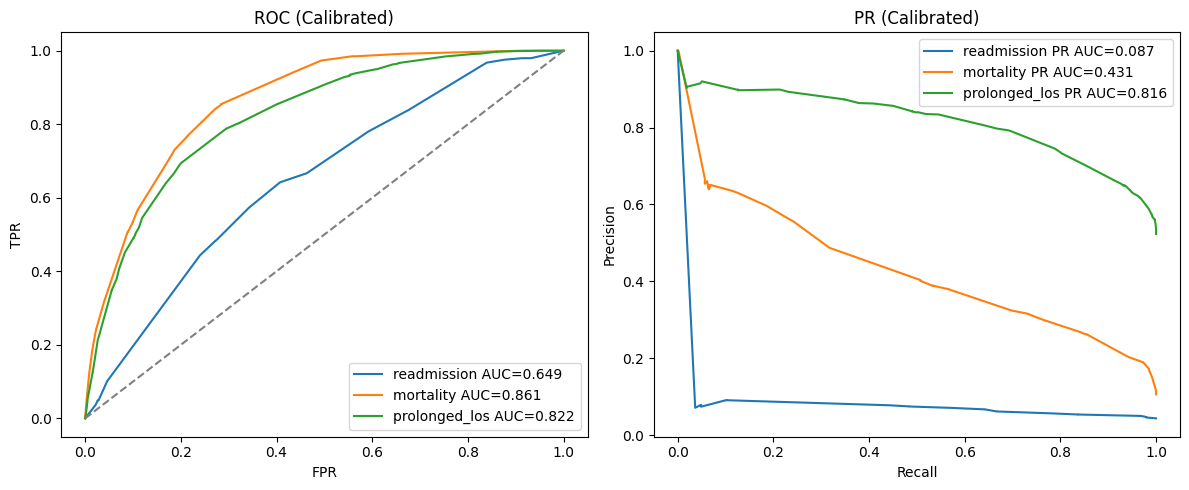

In [13]:
# ROC & PR curves (calibrated) for all targets
import json
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc as sk_auc
from joblib import load as jobload

roc_data = {}
pr_data = {}
for tgt_name, label_col in TARGET_SPECS:
    model_path = ARTIFACTS_DIR / f'model_{tgt_name}.joblib'
    iso_path = ARTIFACTS_DIR / f'isotonic_{tgt_name}.joblib'
    if not (model_path.exists() and iso_path.exists()):
        print('Missing artifacts for', tgt_name)
        continue
    model = jobload(model_path)
    iso = jobload(iso_path)
    y_all = labels_df[label_col].astype(int).to_numpy()
    y_te_t = y_all[idx_te]
    raw = model.predict_proba(X_te)[:,1]
    cal = iso.transform(raw)
    fpr,tpr,_ = roc_curve(y_te_t, cal)
    prec,rec,_ = precision_recall_curve(y_te_t, cal)
    roc_auc = sk_auc(fpr,tpr)
    pr_auc = sk_auc(rec,prec)
    roc_data[tgt_name] = (fpr,tpr,roc_auc)
    pr_data[tgt_name] = (rec,prec,pr_auc)

fig, axes = plt.subplots(1,2, figsize=(12,5))
for tgt,(fpr,tpr,roc_auc) in roc_data.items():
    axes[0].plot(fpr,tpr,label=f"{tgt} AUC={roc_auc:.3f}")
axes[0].plot([0,1],[0,1],'--',color='grey'); axes[0].set_title('ROC (Calibrated)'); axes[0].legend(); axes[0].set_xlabel('FPR'); axes[0].set_ylabel('TPR')
for tgt,(rec,prec,pr_auc) in pr_data.items():
    axes[1].plot(rec,prec,label=f"{tgt} PR AUC={pr_auc:.3f}")
axes[1].set_title('PR (Calibrated)'); axes[1].legend(); axes[1].set_xlabel('Recall'); axes[1].set_ylabel('Precision')
plt.tight_layout(); plt.show()

### Final Model Training
Train final booster on combined train+validation using best params.

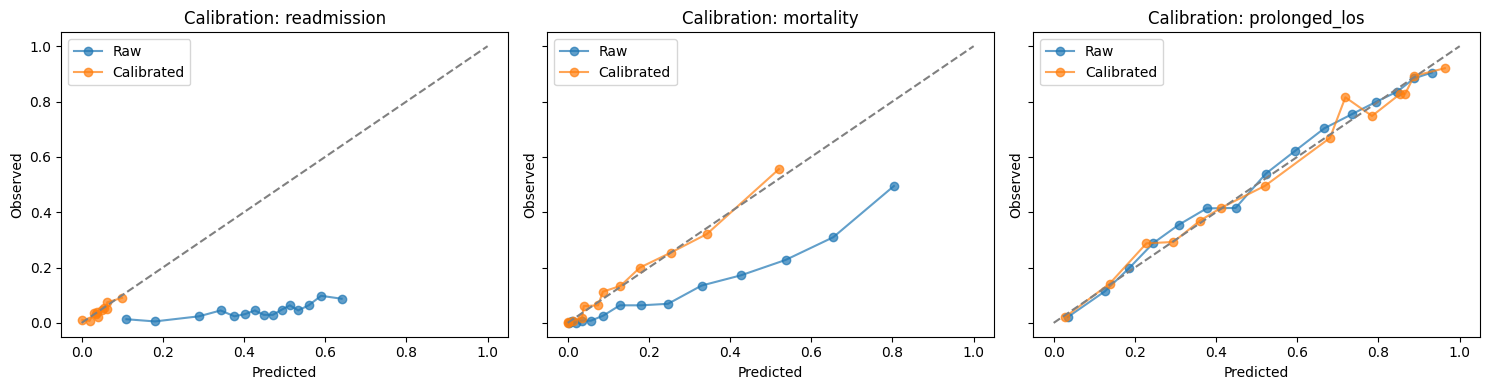

readmission: mean |raw-cal| = 0.38196
mortality: mean |raw-cal| = 0.13024
prolonged_los: mean |raw-cal| = 0.02678


In [14]:
# Calibration curves for all targets (using shared_inference unified loading)
from project.shared_inference import get_model_and_calibrator, apply_calibration, _resolve_models_dir
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
import numpy as np

ARTIFACTS_DIR = _resolve_models_dir()

calibration_targets = []  # (tgt_name, y_true_test, raw_probs, calibrated_probs)
for tgt_name, label_col in TARGET_SPECS:
    try:
        model, calibrator = get_model_and_calibrator(tgt_name, models_dir=ARTIFACTS_DIR)
    except FileNotFoundError:
        print('Skip (missing artifacts):', tgt_name)
        continue
    y_all = labels_df[label_col].astype(int).to_numpy(); y_te_t = y_all[idx_te]
    raw = model.predict_proba(X_te)[:,1]
    cal = apply_calibration(raw, calibrator)
    calibration_targets.append((tgt_name, y_te_t, raw, cal))

if not calibration_targets:
    raise RuntimeError('No targets available for calibration plotting.')

fig, axes = plt.subplots(1, len(calibration_targets), figsize=(5*len(calibration_targets),4), sharey=True)
if len(calibration_targets) == 1:
    axes = [axes]

for ax,(tgt,y_true,raw,cal) in zip(axes, calibration_targets):
    fr_raw, mp_raw = calibration_curve(y_true, raw, n_bins=15, strategy='quantile')
    fr_cal, mp_cal = calibration_curve(y_true, cal, n_bins=15, strategy='quantile')
    ax.plot(mp_raw, fr_raw, 'o-', label='Raw', alpha=0.7)
    ax.plot(mp_cal, fr_cal, 'o-', label='Calibrated', alpha=0.7)
    ax.plot([0,1],[0,1], '--', color='gray')
    ax.set_title(f'Calibration: {tgt}')
    ax.set_xlabel('Predicted'); ax.set_ylabel('Observed')
    ax.legend()
plt.tight_layout(); plt.show()

# Report average absolute calibration shift per target
for tgt, y_true, raw, cal in calibration_targets:
    shift = float(np.mean(np.abs(raw - cal)))
    print(f"{tgt}: mean |raw-cal| = {shift:.5f}")

# SHAP top features per target (sampled)
import numpy as np, pandas as pd
from joblib import load as jobload
shap_results = {}
try:
    import shap
    shap.initjs()
    SAMPLE = 400
    for tgt_name,_ in TARGET_SPECS:
        model_path = ARTIFACTS_DIR / f'model_{tgt_name}.joblib'
        if not model_path.exists():
            continue
        model = jobload(model_path)
        sample_idx = np.random.default_rng(42).choice(len(X_tr), size=min(SAMPLE, len(X_tr)), replace=False)
        explainer = shap.TreeExplainer(model)
        shap_vals = explainer.shap_values(X_tr[sample_idx])
        mean_abs = np.abs(shap_vals).mean(axis=0)
        order = np.argsort(-mean_abs)[:20]
        feat_cols = list(feature_df.columns)
        top_df = pd.DataFrame({'feature':[feat_cols[i] for i in order], 'importance':mean_abs[order]})
        shap_results[tgt_name] = top_df.head(10).to_dict(orient='records')
        ax = top_df.iloc[::-1].plot(kind='barh', x='feature', y='importance', figsize=(6,5), title=f'SHAP Top 20 {tgt_name}')
        ax.set_xlabel('Mean |SHAP|')
        plt.tight_layout(); plt.show()
    print('Top SHAP features (first 10 each):')
    for k,v in shap_results.items():
        print(k, v[:5])
except Exception as e:
    print('SHAP skipped:', e)

In [15]:
# Manual isotonic calibration (sklearn XGBClassifier base, no DMatrix)
from xgboost import XGBClassifier
from sklearn.isotonic import IsotonicRegression
import numpy as np

# Base model: train-only (exclude validation for calibration fairness)
params = study.best_params.copy()
base_model = XGBClassifier(
    objective='binary:logistic', tree_method='hist',
    learning_rate=params['learning_rate'],
    n_estimators=params['n_estimators'],
    max_depth=params['max_depth'],
    min_child_weight=params['min_child_weight'],
    subsample=params['subsample'],
    colsample_bytree=params['colsample_bytree'],
    reg_lambda=params['lambda'],
    reg_alpha=params['alpha'],
    gamma=params['gamma'],
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    verbosity=0
)
base_model.fit(X_tr, y_tr)
val_proba_raw = base_model.predict_proba(X_val)[:,1]
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(val_proba_raw, y_val)
print('Isotonic calibration fitted on validation set.')

def predict_calibrated(X):
    return iso.transform(base_model.predict_proba(X)[:,1])

# Derive operating threshold on calibrated validation probabilities
val_cal = predict_calibrated(X_val)
ths = np.linspace(0.01,0.9,300)
threshold_info = None
for t in ths:
    m = metrics_at(val_cal, y_val, t)
    if (threshold_info is None) or (m['f1'] > threshold_info['f1']):
        threshold_info = {**m, 'threshold': float(t)}
print('Selected threshold (calibrated validation):', threshold_info)

Isotonic calibration fitted on validation set.
Selected threshold (calibrated validation): {'f1': 0.1191672648959081, 'precision': np.float64(0.07242582897026839), 'recall': np.float64(0.33603238866260715), 'cost': np.float64(1883.0), 'fbeta': np.float64(0.19447047766439005), 'threshold': 0.05762541806020067}
Selected threshold (calibrated validation): {'f1': 0.1191672648959081, 'precision': np.float64(0.07242582897026839), 'recall': np.float64(0.33603238866260715), 'cost': np.float64(1883.0), 'fbeta': np.float64(0.19447047766439005), 'threshold': 0.05762541806020067}


### Multi-Outcome Expansion
Train & calibrate additional models for mortality and prolonged LOS using the same feature matrix and pipeline pattern.

In [16]:
# Unified summary table: tuned vs baseline metrics per target
import json, pandas as pd
rows = []
for tgt_name, _ in TARGET_SPECS:
    metrics_path = ARTIFACTS_DIR / f'metrics_{tgt_name}.json'
    if not metrics_path.exists():
        continue
    with open(metrics_path) as f:
        m = json.load(f)
    rows.append({
        'target': tgt_name,
        'auc': m['auc'],
        'pr_auc': m['pr_auc'],
        'brier': m['brier'],
        'threshold': m['threshold'],
        'f1_at_threshold': m['f1_at_threshold'],
        'precision_at_threshold': m['precision_at_threshold'],
        'recall_at_threshold': m['recall_at_threshold'],
        'baseline_val_auc': baseline_results.get(tgt_name)
    })
summary_df = pd.DataFrame(rows)
print(summary_df.sort_values('target'))
summary_df.to_csv(ARTIFACTS_DIR / 'metrics_summary.csv', index=False)
print('Wrote metrics_summary.csv')

          target       auc    pr_auc     brier  threshold  f1_at_threshold  precision_at_threshold  recall_at_threshold  baseline_val_auc
1      mortality  0.861058  0.400824  0.074992   0.206455         0.449754                0.388350             0.534224          0.792318
2  prolonged_los  0.821765  0.806928  0.171392   0.361237         0.769792                0.700498             0.854300          0.802140
0    readmission  0.649249  0.067601  0.041148   0.054649         0.128788                0.074282             0.483740          0.587455
Wrote metrics_summary.csv


In [17]:
# Compare full (train+val) vs base calibrated models on test
from joblib import load as jobload
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss

comparison_rows = []
missing_any = False
for tgt_name, label_col in TARGET_SPECS:
    y_all = labels_df[label_col].astype(int).to_numpy()
    y_te_t = y_all[idx_te]
    full_path = ARTIFACTS_DIR / f'model_full_{tgt_name}.joblib'
    base_path = ARTIFACTS_DIR / f'model_{tgt_name}.joblib'
    iso_path = ARTIFACTS_DIR / f'isotonic_{tgt_name}.joblib'
    if not (full_path.exists() and base_path.exists() and iso_path.exists()):
        print('Skipping', tgt_name, 'missing one of required artifacts')
        missing_any = True
        continue
    full_model = jobload(full_path)
    base_model = jobload(base_path)
    iso = jobload(iso_path)
    raw_full = full_model.predict_proba(X_te)[:,1]
    raw_base = base_model.predict_proba(X_te)[:,1]
    cal_base = iso.transform(raw_base)
    row = {
        'target': tgt_name,
        'full_raw_auc': roc_auc_score(y_te_t, raw_full),
        'full_raw_pr_auc': average_precision_score(y_te_t, raw_full),
        'base_raw_auc': roc_auc_score(y_te_t, raw_base),
        'base_cal_auc': roc_auc_score(y_te_t, cal_base),
        'base_cal_pr_auc': average_precision_score(y_te_t, cal_base),
        'base_cal_brier': brier_score_loss(y_te_t, cal_base)
    }
    comparison_rows.append(row)

comparison_df = pd.DataFrame(comparison_rows)
if len(comparison_df):
    display(comparison_df.sort_values('target'))
    comparison_df.to_csv(ARTIFACTS_DIR / 'full_vs_calibrated_comparison.csv', index=False)
    print('Wrote full_vs_calibrated_comparison.csv')
else:
    print('No comparison rows generated.')

,target,full_raw_auc,full_raw_pr_auc,base_raw_auc,base_cal_auc,base_cal_pr_auc,base_cal_brier
1,mortality,0.864259,0.428864,0.862605,0.861058,0.400824,0.074992
2,prolonged_los,0.824782,0.819913,0.822717,0.821765,0.806928,0.171392
0,readmission,0.658868,0.072560,0.652448,0.649249,0.067601,0.041148


Wrote full_vs_calibrated_comparison.csv


### Full vs Calibrated Model Comparison
Compares raw discrimination of `model_full_*` (trained on train+val) against raw and calibrated outputs of the train-only `model_*` + isotonic. This helps quantify the trade-off (if any) from using the calibration protocol.

In [18]:
# Merge comparison with metrics summary (enriched)
import pandas as pd, json
summary_path = ARTIFACTS_DIR / 'metrics_summary.csv'
comp_path = ARTIFACTS_DIR / 'full_vs_calibrated_comparison.csv'
if summary_path.exists() and comp_path.exists():
    summary_df = pd.read_csv(summary_path)
    comp_df = pd.read_csv(comp_path)
    merged = summary_df.merge(comp_df, on='target', how='left')
    merged.to_csv(ARTIFACTS_DIR / 'metrics_summary_enriched.csv', index=False)
    print('Wrote metrics_summary_enriched.csv')
    display(merged.sort_values('target'))
else:
    print('Missing one of summary or comparison CSV; skip enrichment.')

Wrote metrics_summary_enriched.csv


,target,auc,pr_auc,brier,threshold,f1_at_threshold,precision_at_threshold,recall_at_threshold,baseline_val_auc,full_raw_auc,full_raw_pr_auc,base_raw_auc,base_cal_auc,base_cal_pr_auc,base_cal_brier
1,mortality,0.861058,0.400824,0.074992,0.206455,0.449754,0.388350,0.534224,0.792318,0.864259,0.428864,0.862605,0.861058,0.400824,0.074992
2,prolonged_los,0.821765,0.806928,0.171392,0.361237,0.769792,0.700498,0.854300,0.802140,0.824782,0.819913,0.822717,0.821765,0.806928,0.171392
0,readmission,0.649249,0.067601,0.041148,0.054649,0.128788,0.074282,0.483740,0.587455,0.658868,0.072560,0.652448,0.649249,0.067601,0.041148


In [19]:
# AUC Difference Significance (Bootstrap between full_raw and base_cal)
import numpy as np, pandas as pd
from joblib import load as jobload
from sklearn.metrics import roc_auc_score

RESULTS = []
N_BOOT = 2000  # increase for tighter CI (runtime ~ O(N_BOOT))
RNG = np.random.default_rng(42)

for tgt_name, label_col in TARGET_SPECS:
    full_path = ARTIFACTS_DIR / f'model_full_{tgt_name}.joblib'
    base_path = ARTIFACTS_DIR / f'model_{tgt_name}.joblib'
    iso_path = ARTIFACTS_DIR / f'isotonic_{tgt_name}.joblib'
    if not (full_path.exists() and base_path.exists() and iso_path.exists()):
        print('Skip significance for', tgt_name, '(missing artifacts)')
        continue
    y_all = labels_df[label_col].astype(int).to_numpy()
    y_te_t = y_all[idx_te]
    full_model = jobload(full_path)
    base_model = jobload(base_path)
    iso = jobload(iso_path)
    raw_full = full_model.predict_proba(X_te)[:,1]
    cal_base = iso.transform(base_model.predict_proba(X_te)[:,1])
    auc_full = roc_auc_score(y_te_t, raw_full)
    auc_cal = roc_auc_score(y_te_t, cal_base)
    diff = auc_full - auc_cal
    n = len(y_te_t)
    # Bootstrap
    diffs = np.empty(N_BOOT)
    for b in range(N_BOOT):
        idx = RNG.integers(0, n, size=n)
        y_b = y_te_t[idx]
        rf_b = raw_full[idx]
        cb_b = cal_base[idx]
        try:
            diffs[b] = roc_auc_score(y_b, rf_b) - roc_auc_score(y_b, cb_b)
        except ValueError:
            # In rare case bootstrap sample has only one class
            diffs[b] = np.nan
    diffs = diffs[~np.isnan(diffs)]
    if len(diffs) < N_BOOT * 0.9:
        print('Warning: many degenerate bootstrap samples for', tgt_name)
    lower, upper = np.percentile(diffs, [2.5, 97.5])
    # Two-sided p-value: proportion of bootstrap diffs with opposite sign or more extreme
    if diff >= 0:
        p = (np.sum(diffs <= 0) + 1) / (len(diffs) + 1)
    else:
        p = (np.sum(diffs >= 0) + 1) / (len(diffs) + 1)
    RESULTS.append({
        'target': tgt_name,
        'auc_full_raw': auc_full,
        'auc_base_cal': auc_cal,
        'diff_full_minus_cal': diff,
        'ci_95_lower': lower,
        'ci_95_upper': upper,
        'approx_p_two_sided': p * 2 if p * 2 <= 1 else 1.0,
        'n_test': n,
        'n_boot_effective': int(len(diffs))
    })

if RESULTS:
    sig_df = pd.DataFrame(RESULTS).sort_values('target')
    display(sig_df)
    sig_df.to_csv(ARTIFACTS_DIR / 'auc_diff_significance.csv', index=False)
    print('Wrote auc_diff_significance.csv')
else:
    print('No targets processed for significance analysis.')

,target,auc_full_raw,auc_base_cal,diff_full_minus_cal,ci_95_lower,ci_95_upper,approx_p_two_sided,n_test,n_boot_effective
1,mortality,0.864259,0.861058,0.003201,-0.001591,0.007945,0.191904,5668,2000
2,prolonged_los,0.824782,0.821765,0.003017,0.000643,0.005415,0.013993,5668,2000
0,readmission,0.658868,0.649249,0.009619,-0.007953,0.026638,0.269865,5668,2000


Wrote auc_diff_significance.csv


In [20]:
# Leakage Audit: heuristic checks for potential target leakage across features
import re, json, numpy as np, pandas as pd
from sklearn.metrics import roc_auc_score

print('\n=== Leakage Audit Start ===')

# 1. Basic presence checks
if 'feature_df' not in globals():
    raise RuntimeError('feature_df not found in notebook namespace.')

suspicious_substrings = [
    'los', 'readmit', 'readmission', 'mort', 'death', 'dod', 'deathtime',
    'discharge', 'outcome', 'label', 'future'
]
pattern = re.compile('|'.join([re.escape(s) for s in suspicious_substrings]), re.IGNORECASE)

all_features = list(feature_df.columns)
matched_features = [f for f in all_features if pattern.search(f)]
print(f'Total features: {len(all_features)} | Suspicious-matched: {len(matched_features)}')

# Exclude obviously safe tokens that create false positives (tune if needed)
false_positive_tokens = {'mortality_risk_score_placeholder'}
matched_features = [f for f in matched_features if f.lower() not in false_positive_tokens]

print('Sample suspicious feature names (up to 25):')
for name in matched_features[:25]:
    print('  -', name)

# 2. Per-target single-feature AUCs (very high AUC alone may indicate leakage)
per_target_auc = {}
if 'labels_df' in globals():
    for tgt_name, label_col in [('readmission','readmission_label'), ('mortality','mortality_label'), ('prolonged_los','prolonged_los_label')]:
        if label_col not in labels_df.columns:  # skip missing targets
            continue
        y = labels_df.set_index('subject_id')[label_col].reindex(feature_df.index).astype(float).values
        auc_rows = []
        for f in matched_features:
            x = feature_df[f].values
            # Skip constant
            if np.nanstd(x) < 1e-9:
                continue
            try:
                # For continuous feature use raw values; sklearn will treat >2 class distribution
                auc = roc_auc_score(y, x)
                auc_rows.append((f, auc))
            except ValueError:
                # Probably only one class present in y subset or feature has too few distinct values
                continue
        # Sort by AUC descending
        auc_rows.sort(key=lambda r: r[1], reverse=True)
        per_target_auc[tgt_name] = auc_rows[:20]

print('\nTop suspicious-feature single-variable AUCs (first 20 per target):')
for tgt, rows in per_target_auc.items():
    if not rows:
        print(f'  {tgt}: (no evaluable suspicious features)')
        continue
    print(f'  {tgt}:')
    for f, auc in rows:
        flag = ' **LEAK?**' if auc >= 0.9 else ''
        print(f'    {f}: AUC={auc:.3f}{flag}')

# 3. Variance & near-deterministic checks for prolonged LOS leakage (features containing "los")
los_feats = [f for f in matched_features if 'los' in f.lower()]
los_flags = []
for f in los_feats:
    x = feature_df[f].values
    unique_vals = np.unique(x[~pd.isna(x)])
    if len(unique_vals) <= 2:
        # Binary LOS-derived feature: check overlap with target
        if 'prolonged_los_label' in labels_df.columns:
            y_pl = labels_df.set_index('subject_id')['prolonged_los_label'].reindex(feature_df.index).values
            try:
                auc_bin = roc_auc_score(y_pl, x)
            except ValueError:
                auc_bin = float('nan')
            if (np.array_equal(x, y_pl) or np.array_equal(1 - x, y_pl)):
                los_flags.append((f, 'IDENTICAL_TO_TARGET'))
            elif auc_bin >= 0.9:
                los_flags.append((f, f'HIGH_AUC_{auc_bin:.3f}'))
    else:
        # Continuous LOS-like feature: if max value >> 48 early-window hours, could leak realized LOS
        if np.nanmax(x) > 72:  # heuristic threshold (48h window + slack)
            los_flags.append((f, f'MAX_GT_72({np.nanmax(x):.1f})'))

if los_flags:
    print('\nPotential LOS leakage flags:')
    for f, reason in los_flags:
        print(f'  - {f}: {reason}')
else:
    print('\nNo LOS leakage heuristics triggered.')

# 4. Remove known non-leak columns from matched list if we want to persist a clean report (optional)
report = {
    'n_total_features': len(all_features),
    'n_suspicious_matched': len(matched_features),
    'top_single_feature_auc_per_target': {
        tgt: [{'feature': f, 'auc': float(a)} for f,a in rows] for tgt, rows in per_target_auc.items()
    },
    'los_flags': [{'feature': f, 'reason': r} for f,r in los_flags],
    'suspicious_sample': matched_features[:50]
}

with open(ARTIFACTS_DIR / 'leakage_audit.json', 'w') as f:
    json.dump(report, f, indent=2)
print('\nLeakage audit report written to', (ARTIFACTS_DIR / 'leakage_audit.json').resolve())
print('=== Leakage Audit Complete ===')


=== Leakage Audit Start ===
Total features: 1500 | Suspicious-matched: 5
Sample suspicious feature names (up to 25):
  - cyclosporin__measured_y
  - unintentional weight loss >10 lbs.__measured
  - emotional / physical / sexual harm by partner or close relation__measured
  - discharge needs__measured
  - cyclosporin__measured_x

Top suspicious-feature single-variable AUCs (first 20 per target):
  readmission: (no evaluable suspicious features)
  mortality: (no evaluable suspicious features)
  prolonged_los: (no evaluable suspicious features)

No LOS leakage heuristics triggered.

Leakage audit report written to C:\Users\Almog Luz\Documents\GitHub\mlhc-final-project\project\artifacts\leakage_audit.json
=== Leakage Audit Complete ===

Top suspicious-feature single-variable AUCs (first 20 per target):
  readmission: (no evaluable suspicious features)
  mortality: (no evaluable suspicious features)
  prolonged_los: (no evaluable suspicious features)

No LOS leakage heuristics triggered.



In [21]:
# Extended Feature Importance & Suspicious Feature Surfacing
import json, re, numpy as np, pandas as pd
from pathlib import Path
from joblib import load as jobload

print('\n=== Feature Importance & Suspicion Scan ===')
if 'feature_df' not in globals():
    raise RuntimeError('feature_df not in scope; run earlier cells first.')

# Map f0..fN to actual column names (training used raw numpy arrays)
feature_names = list(feature_df.columns)
name_map = {f'f{i}': feature_names[i] for i in range(len(feature_names))}

importance_rows = []
for tgt_name, _lbl in [('readmission','readmission_label'), ('mortality','mortality_label'), ('prolonged_los','prolonged_los_label')]:
    model_path = ARTIFACTS_DIR / f'model_{tgt_name}.joblib'  # calibrated base model (train-only)
    if not model_path.exists():
        print(f'Skip {tgt_name}: model file missing -> {model_path}')
        continue
    model = jobload(model_path)
    try:
        booster = model.get_booster()
    except Exception as e:
        print(f'Skip {tgt_name}: cannot extract booster ({e})')
        continue
    gain_scores = booster.get_score(importance_type='gain')  # dict fidx -> gain
    total_gain = sum(gain_scores.values()) or 1.0
    for f_idx, gain in gain_scores.items():
        col_name = name_map.get(f_idx, f_idx)
        importance_rows.append({
            'target': tgt_name,
            'xgb_feature': f_idx,
            'feature_name': col_name,
            'gain': gain,
            'gain_frac': gain / total_gain
        })

imp_df = pd.DataFrame(importance_rows)
if not imp_df.empty:
    imp_df['rank_within_target'] = imp_df.groupby('target')['gain'].rank(ascending=False, method='first')
    imp_df_sorted = imp_df.sort_values(['target','rank_within_target'])
    imp_out_csv = ARTIFACTS_DIR / 'feature_importance_gain.csv'
    imp_df_sorted.to_csv(imp_out_csv, index=False)
    print('Wrote feature importance CSV ->', imp_out_csv.resolve())
else:
    print('No importance data collected.')

# Suspicion scan (reuse pattern similar to leakage audit)
suspicious_substrings = [ 'los', 'readmit', 'readmission', 'mort', 'death', 'dod', 'discharge', 'outcome', 'label', 'future' ]
pattern = re.compile('|'.join([re.escape(s) for s in suspicious_substrings]), re.IGNORECASE)
imp_df_sorted['suspicious_name_match'] = imp_df_sorted['feature_name'].apply(lambda x: bool(pattern.search(str(x)))) if not imp_df.empty else []

# Flag features that are BOTH suspicious name matches AND high relative importance (top 5% by gain within target)
flags = []
if not imp_df.empty:
    for tgt, grp in imp_df_sorted.groupby('target'):
        cutoff_rank = max(1, int(len(grp) * 0.05))
        top_grp = grp.nsmallest(cutoff_rank, 'rank_within_target')
        flagged = top_grp[top_grp['suspicious_name_match']]
        for _, row in flagged.iterrows():
            flags.append({
                'target': tgt,
                'feature_name': row['feature_name'],
                'gain_frac': float(row['gain_frac']),
                'rank': int(row['rank_within_target'])
            })

report = {
    'n_features': len(feature_names),
    'n_importance_rows': int(len(imp_df)),
    'suspicion_flags': flags,
    'suspicious_name_pattern': suspicious_substrings,
}
with open(ARTIFACTS_DIR / 'feature_importance_suspicious.json', 'w') as f:
    json.dump(report, f, indent=2)
print('Suspicion report written ->', (ARTIFACTS_DIR / 'feature_importance_suspicious.json').resolve())

# Display concise summary
if flags:
    print('\nHigh-importance suspicious feature candidates:')
    for f in flags[:40]:
        print(f"  [{f['target']}] {f['feature_name']} | gain_frac={f['gain_frac']:.4f} | rank={f['rank']}")
else:
    print('No high-importance suspicious feature names flagged.')
print('=== Feature Importance Scan Complete ===')


=== Feature Importance & Suspicion Scan ===
Wrote feature importance CSV -> C:\Users\Almog Luz\Documents\GitHub\mlhc-final-project\project\artifacts\feature_importance_gain.csv
Suspicion report written -> C:\Users\Almog Luz\Documents\GitHub\mlhc-final-project\project\artifacts\feature_importance_suspicious.json
No high-importance suspicious feature names flagged.
=== Feature Importance Scan Complete ===
Wrote feature importance CSV -> C:\Users\Almog Luz\Documents\GitHub\mlhc-final-project\project\artifacts\feature_importance_gain.csv
Suspicion report written -> C:\Users\Almog Luz\Documents\GitHub\mlhc-final-project\project\artifacts\feature_importance_suspicious.json
No high-importance suspicious feature names flagged.
=== Feature Importance Scan Complete ===


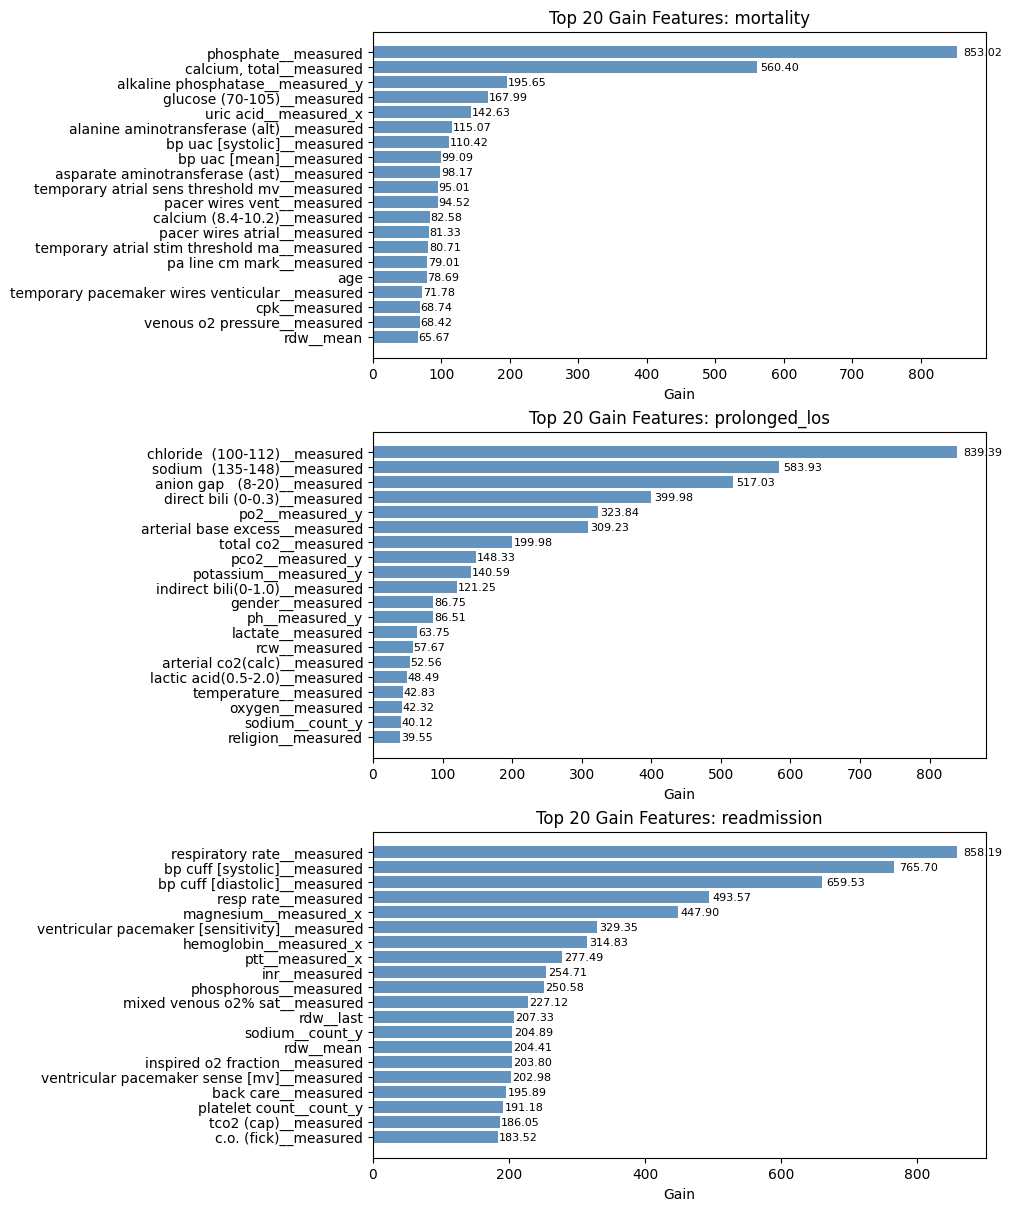

Saved feature importance plots:
  - C:\Users\Almog Luz\Documents\GitHub\mlhc-final-project\project\artifacts\feature_importance_top20_mortality.png
  - C:\Users\Almog Luz\Documents\GitHub\mlhc-final-project\project\artifacts\feature_importance_top20_prolonged_los.png
  - C:\Users\Almog Luz\Documents\GitHub\mlhc-final-project\project\artifacts\feature_importance_top20_readmission.png
No suspicious high-importance features flagged in prior step.


In [22]:
# Visualize Feature Importances (Top 20 per target) with Suspicion Highlight
import pandas as pd, json, matplotlib.pyplot as plt
from pathlib import Path

imp_csv = ARTIFACTS_DIR / 'feature_importance_gain.csv'
flags_json = ARTIFACTS_DIR / 'feature_importance_suspicious.json'

if not imp_csv.exists():
    raise FileNotFoundError(f'Missing importance file: {imp_csv}. Run previous cell first.')

imp_df = pd.read_csv(imp_csv)
flagged = set()
if flags_json.exists():
    try:
        with open(flags_json) as f:
            rep = json.load(f)
        for item in rep.get('suspicion_flags', []):
            flagged.add((item['target'], item['feature_name']))
    except Exception as e:
        print('Could not parse suspicion flags JSON:', e)

# Ensure consistent ordering by gain within each target
imp_df['gain_rank'] = imp_df.groupby('target')['gain'].rank(ascending=False, method='first')

TARGETS = sorted(imp_df['target'].unique())
fig_rows = len(TARGETS)
fig, axes = plt.subplots(fig_rows, 1, figsize=(10, 4*fig_rows), constrained_layout=True)
if fig_rows == 1:
    axes = [axes]

img_paths = []
for ax, tgt in zip(axes, TARGETS):
    subset = imp_df[imp_df['target']==tgt].nsmallest(20, 'gain_rank')
    subset = subset.sort_values('gain', ascending=True)  # for horizontal bar
    colors = ['crimson' if (tgt, fn) in flagged else 'steelblue' for fn in subset['feature_name']]
    ax.barh(subset['feature_name'], subset['gain'], color=colors, alpha=0.85)
    ax.set_title(f'Top 20 Gain Features: {tgt}')
    ax.set_xlabel('Gain')
    for i,(g,f) in enumerate(zip(subset['gain'], subset['feature_name'])):
        ax.text(g*1.01, i, f'{g:.2f}', va='center', fontsize=8)
    # Legend once
    if any(c=='crimson' for c in colors):
        from matplotlib.lines import Line2D
        legend_elems = [Line2D([0],[0], color='steelblue', lw=6, label='Normal'), Line2D([0],[0], color='crimson', lw=6, label='Suspicious')]
        ax.legend(handles=legend_elems, loc='lower right')

plt.show()

# Save per-target PNGs
for tgt in TARGETS:
    fig_t, ax_t = plt.subplots(figsize=(6,6))
    subset = imp_df[imp_df['target']==tgt].nsmallest(20, 'gain_rank')
    subset = subset.sort_values('gain', ascending=True)
    colors = ['crimson' if (tgt, fn) in flagged else 'steelblue' for fn in subset['feature_name']]
    ax_t.barh(subset['feature_name'], subset['gain'], color=colors, alpha=0.9)
    ax_t.set_title(f'Top 20 Gain Features: {tgt}')
    ax_t.set_xlabel('Gain')
    plt.tight_layout()
    out_path = ARTIFACTS_DIR / f'feature_importance_top20_{tgt}.png'
    fig_t.savefig(out_path, dpi=150)
    img_paths.append(out_path)
    plt.close(fig_t)

print('Saved feature importance plots:')
for p in img_paths:
    print('  -', p.resolve())

# Display flagged suspicious features table (if any)
if flagged:
    flagged_rows = []
    for tgt, fn in flagged:
        row = imp_df[(imp_df['target']==tgt) & (imp_df['feature_name']==fn)]
        if not row.empty:
            flagged_rows.append(row.iloc[0])
    if flagged_rows:
        flagged_df = pd.DataFrame(flagged_rows).sort_values(['target','gain_rank'])
        display(flagged_df[['target','feature_name','gain','gain_frac','gain_rank']])
    else:
        print('No flagged features present in top importance list (flags may refer to excluded ranks).')
else:
    print('No suspicious high-importance features flagged in prior step.')